In [1]:
!pip install contractions
!pip install langdetect

!apt update
!apt install enchant --fix-missing
!apt install -qq enchant
!pip install pyenchant

!pip install pyenchant
!pip install scikeras


Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, GRU, Flatten, Dense, BatchNormalization, Dropout, Concatenate, Lambda
from tensorflow.keras.utils import to_categorical

from scikeras.wrappers import KerasClassifier
from scipy.linalg import svd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from collections import defaultdict, Counter
import enchant
import contractions
import re

%matplotlib inline

[nltk_data] Downloading package punkt to /home/andrea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/andrea/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andrea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1) Input
- **Which fields to be used to predict the rating?**

For the purpose of predicting the rating, three key fields have been selected: "Review_Text," "Year_Month," and "Branch." Each of these fields contributes valuable insights to the analysis.

The field <code>Review_Text</code> holds utmost significance as it encompasses the primary feature of the dataset. It comprises the customers' feedback and reviews regarding the amusement park. Analyzing the textual data allows for the identification of sentiment, key themes, and specific aspects of the park that are frequently mentioned. Applying appropriate Natural Language Processing (NLP) techniques facilitates the extraction of meaningful information from the text.

The <code>Year_Month</code> field provides temporal information, allowing for the observation of patterns and trends over time. By considering the month and year of each review, it becomes possible to identify seasonal variations in customer satisfaction or changes in the park's offerings and management practices that may influence ratings.

Additionally, the <code>Branch</code> field indicates the specific location or branch of the amusement park. Analyzing ratings based on different branches enables the identification of potential variations in customer experiences across locations. This analysis may shed light on unique characteristics or operational differences between branches that contribute to differences in customer satisfaction.

By incorporating these three fields as input features for rating prediction, the analysis encompasses textual information, temporal trends, and location-specific patterns. This comprehensive approach aims to gain a deeper understanding of the factors influencing customer ratings at the amusement park.

In [3]:
# Read dataset
df = pd.read_csv("https://github.com/MikiTwenty/Python/blob/main/Colab/DL-Exam/parkReviews.csv?raw=true", encoding='latin-1')
df = df.replace('missing', np.nan)
df.head()

,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong


In [4]:
# extract reviews, year, month, branch and labels

X = df[['Review_Text', 'Year_Month', 'Branch']]
       
y = df['Rating']

# Create a copy of X before modifying it
X_copy = X.copy()


# Reduce dataset size by 80%
X_trash, X_cut, y_trash, y_cut = train_test_split(X_copy, y, test_size=0.2, stratify=y, random_state=42)

# Rename reduced dataset
X, y = X_cut, y_cut

print(f"len(X): {len(X)}")
print(f"len(y): {len(y)}\n")

len(X): 8532
len(y): 8532



In [5]:
X.head()

,Review_Text,Year_Month,Branch
31462,How Disney can be rated anything other than 5*...,2017-7,Disneyland_Paris
29019,I have been fortunate enough to be able to vis...,NaN,Disneyland_California
18701,"Always fun, always clean, always a thrill. The...",2014-7,Disneyland_California
2708,Slightly disappointed during our visit to Disn...,2017-2,Disneyland_HongKong
32737,We booked tickets for Disneyland Paris for a d...,2016-12,Disneyland_Paris


In [6]:
# Define function to get statistics about reviews

def get_max_mean(reviews):

    # Max Number of Words
    max_n_words = max([len(review.split()) for review in reviews])

    # Mean Number of Words
    tot_n_word=0
    for review in reviews:
        tot_n_word += len(review.split())

    mean_n_words = tot_n_word / len(reviews)

    return max_n_words, mean_n_words

In [7]:
# Review_Text Statistics
max_n_words, mean_n_words = get_max_mean(X['Review_Text'])

print(f"mean_n_words: {round(mean_n_words, 2)}")
print(f"max_n_words: {max_n_words}")

mean_n_words: 130.45
max_n_words: 3278


- **How to (possibly) process/transform each field used?**


**Text:**

1. Lowercasing: Convert all words to lowercase to ensure consistency and avoid duplication based on case sensitivity.
2. Handling Contractions: Expand or resolve contractions and abbreviated forms of words to maintain standardization and improve text understanding.
3. Removal of Punctuation: Delete punctuation marks from the text to focus on the actual words and reduce noise.
4. Stop Word Removal: Eliminate common words, known as stop words, from the text as they often carry little semantic meaning and can be safely disregarded.

After analyzing the textual data and plotting the most frequent words in the reviews, it is advisable to remove the following words:

- Words that appear frequently: These words may not contribute much to the predictive power as they are likely generic terms.
- Words that appear only once: These words are not likely to provide meaningful insights due to their infrequency.
- Words composed of two letters or less: Such short words are often prepositions or conjunctions that don't carry substantial semantic value.
- Words that do not belong to the English vocabulary: Removing non-English words ensures the focus remains on relevant terms within the given context.

**Branch:**
Apply one-hot encoding to represent the "Branch" feature as a three-dimensional vector. Afterwards, drop the first column to reduce the dimensionality while preserving the necessary information.

**Year_Month:**

1. SimpleImputer(strategy='most_frequent'): Fill any missing values in the "Year_Month" feature using the most frequent value, ensuring completeness of the dataset.
2. Split in two columns: Split the "Year_Month" feature into two separate columns, namely "Year" and "Month," to facilitate temporal analysis.
3. Apply normalization: Normalize the "Year" and "Month" columns using an appropriate scaling technique to bring the values within a specific range and ensure uniformity for further analysis.

### TEXT

In [8]:
# Lowercasing
REVIEWS = [review.lower() for review in X['Review_Text']]

In [9]:
# Handling Contractions
REVIEWS = [contractions.fix(review) for review in REVIEWS]

In [10]:
# Removal of punctuation
def remove_punctuation(text):
    no_punct = re.sub(r"[^\w\s]", "", text)
    return no_punct

REVIEWS = [remove_punctuation(review) for review in REVIEWS]

In [11]:
## Stop word removal
def remove_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(sentence)
    filtered_tokens = [word for word in tokens if word.casefold() not in stop_words]
    filtered_sentence = ' '.join(filtered_tokens)
    return filtered_sentence

REVIEWS = [remove_stopwords(review) for review in REVIEWS]

In [12]:
# Reviews Statistics
max_n_words, mean_n_words = get_max_mean(REVIEWS)

print(f"mean_n_words: {round(mean_n_words, 2)}")
print(f"max_n_words: {max_n_words}")

mean_n_words: 65.99
max_n_words: 1557


In [13]:
# Word count
word_counter = Counter()

# Iterate over each sentence and update the word counts
for review in REVIEWS:
    words = review.split()
    word_counter.update(words)

In [14]:
# Sort the word_counter in decreasing order by count
SORTED_COUNTS = sorted(word_counter.items(), key=lambda x: x[1], reverse=True)

# Separate the words and counts into separate lists
words = [word for word, count in SORTED_COUNTS]
counts = [count for word, count in SORTED_COUNTS]

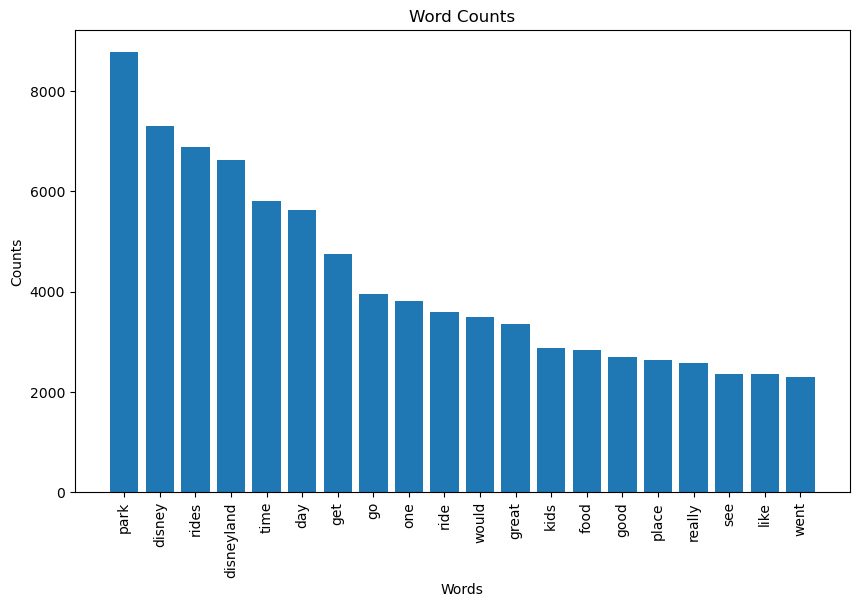

In [15]:
# Plot the word counts in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(words[:20], counts[:20])

plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Counts')
plt.xticks(rotation=90)

plt.show()

In [16]:
dictionary = enchant.Dict("en_US")
filtered_word_counts = []

# Words that appear more than once
filtered_word_counts = [(word, count) for word, count in SORTED_COUNTS if count > 1]

# Words with more than 2 characters
filtered_word_counts = [(word, count) for word, count in filtered_word_counts if len(word) > 2]

# Words which are in the english vocabulary
filtered_word_counts = [(word, count) for word, count in filtered_word_counts if dictionary.check(word)]

len(SORTED_COUNTS), len(filtered_word_counts)

(27415, 8605)

In [17]:
most_freq_words = ['park', 'disney', 'rides', 'disneyland']
unique_words = [word for word,count in SORTED_COUNTS if count == 1]
short_words = [word for word, count in SORTED_COUNTS if len(word) <= 2]
non_english_words = [word for word,count in SORTED_COUNTS if not dictionary.check(word)]


words_to_remove = []
words_to_remove.extend(most_freq_words)
words_to_remove.extend(unique_words)
words_to_remove.extend(short_words)
words_to_remove.extend(non_english_words)
words_to_remove = set(words_to_remove)

print(f"len(most_freq_words) = {len(most_freq_words)}")
print(f"len(unique_words) = {len(unique_words)}")
print(f"len(short_words) = {len(short_words)}")
print(f"len(non_english_words) = {len(non_english_words)}\n")

print(f"Total unique words = {len(SORTED_COUNTS)}")
print(f"len(useless_words) = {len(words_to_remove)}\n")

print(f"Remaining words after processing = {len(SORTED_COUNTS) - len(words_to_remove)}")

len(most_freq_words) = 4
len(unique_words) = 15995
len(short_words) = 370
len(non_english_words) = 14248

Total unique words = 27415
len(useless_words) = 18812

Remaining words after processing = 8603


In [18]:
filtered_reviews = []

for r in REVIEWS:
    filtered_review = []
    words = r.split()
    for w in words:
        if w in words_to_remove:
            continue
        filtered_review.append(w)

    filtered_review = " ".join(filtered_review)
    filtered_reviews.append(filtered_review)

In [19]:
# Filtered Reviews Statistics
max_n_words, mean_n_words = get_max_mean(filtered_reviews)

print(f"mean_n_words: {round(mean_n_words, 2)}")
print(f"max_n_words: {max_n_words}")

mean_n_words: 54.44
max_n_words: 1239


In [20]:
 #cut reviews at 60 words
cut_reviews = []

MAX_LENGTH = 60

for r in filtered_reviews:
    LENGTH = len(r.split())

    if LENGTH > MAX_LENGTH:
        r = " ".join(r.split()[:MAX_LENGTH])
        cut_reviews.append(r)
        continue

    if LENGTH < 60:
        r = r.split() + ["<UNK>"] * (MAX_LENGTH - LENGTH)
        cut_reviews.append(" ".join(r))
        continue

    else:
        cut_reviews.append(r)

In [21]:
cut_reviews[0]

'rated anything beyond magical exciting fun something new unexpected around every corner new shows parades different seasons along different characters meet every day keep fresh new extra magic hours perfection option take advantage bit quieter definitely extra special wait til saved enough pennies place <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

In [22]:
def compute_co_occurrence_matrix(reviews, window_size):
    co_occurrence_matrix = defaultdict(int)

    for review in reviews:

        words = review.split()

        for i, word in enumerate(words):

            start = max(0, i - window_size + 1)
            end = min(len(words), i + window_size + 1)

            context_words = words[start:end]

            for context_word in context_words:

                if context_word != word:
                    co_occurrence_matrix[(word, context_word)] += 1
                else:
                    co_occurrence_matrix[(word, context_word)] += 0




    word_list = sorted(set(word for word, _ in co_occurrence_matrix.keys()))
    num_words = len(word_list)

    co_occurrence_array = (np.zeros((num_words, num_words), dtype=np.int32))

    for (word, context_word), count in co_occurrence_matrix.items():

        i = word_list.index(word)
        j = word_list.index(context_word)

        co_occurrence_array[i,j] = count


    # modify "<UNK>" vals
    i = word_list.index('<UNK>')
    co_occurrence_array[:, i] = np.zeros(co_occurrence_array[:, i].shape)
    co_occurrence_array[i, :] = np.zeros(co_occurrence_array[i, :].shape)

    return co_occurrence_array, word_list

In [23]:
#co_occurrence_array, word_list = compute_co_occurrence_matrix(cut_reviews, window_size=3)
#co_occurrence_array

In [24]:
#co_occurrence_array = co_occurrence_array.astype(float)

In [25]:
# Save co-occurrence matrix
#np.save('co_occurrence_matrix.npy', co_occurrence_array)
#np.save('word_list.npy', word_list)

In [26]:
co_occurrence_matrix = np.load('co_occurrence_matrix.npy')
word_list = np.load('word_list.npy')

In [27]:
# pca 100 dimensions
#n_components = 100
#pca = PCA(n_components=n_components)
#co_occurrence_100d = pca.fit_transform(co_occurrence_matrix)

# pca 200 dimensions
#n_components = 200
#pca = PCA(n_components=n_components)
#co_occurrence_200d = pca.fit_transform(co_occurrence_matrix)

# pca 300 dimensions
#n_components = 300
#pca = PCA(n_components=n_components)
#co_occurrence_300d = pca.fit_transform(co_occurrence_matrix)

In [28]:
# co_occurrence_matrix and its reductions are computed a priori. I'm exporting them from my github to save time.
#!git clone https://github.com/andrealolli13/DeepLearning.git

In [29]:
# Save co-occurrence_reduced matrix
#np.save('co_occurrence_100d.npy', co_occurrence_100d)
#np.save('co_occurrence_200d.npy', co_occurrence_200d)
#np.save('co_occurrence_300d.npy', co_occurrence_300d)
#
co_occurrence_100d = np.load('co_occurrence_100d.npy')
co_occurrence_200d = np.load('co_occurrence_200d.npy')
co_occurrence_300d = np.load('co_occurrence_300d.npy')


# Check the shape of the reduced matrix
print(co_occurrence_100d.shape, co_occurrence_200d.shape, co_occurrence_300d.shape)

(8065, 100) (8065, 200) (8065, 300)


In [30]:
## Word to int
word_list = np.load('word_list.npy')
str_to_int = {w:i for i, w in enumerate(word_list)}
int_to_str = {i:w for i, w in enumerate(word_list)}

In [31]:
# Tokenization process
ENCODED_REVIEWS = []

for r in cut_reviews:
    words = r.split()
    for i, w in enumerate(words, 0):
        number = str_to_int[w]
        words[i] = number
    enc_rev = words
    ENCODED_REVIEWS.append(enc_rev)

### Year_Month

In [32]:
year_month = X['Year_Month']
print(f"Missing values in 'Year_Month': {year_month.isnull().sum()}")

# Fix Missing values
si = SimpleImputer(strategy='most_frequent')
year_month = si.fit_transform(year_month.to_numpy().reshape(-1, 1))
year_month = pd.Series(year_month.flatten())

print(f"Missing values in 'Year_Month' after imputation: {year_month.isnull().sum()}")

Missing values in 'Year_Month': 530
Missing values in 'Year_Month' after imputation: 0


In [33]:
# Split feature in year, month
year = np.array([date.split('-')[0] for date in year_month]).astype('float')
month = np.array([date.split('-')[1] for date in year_month]).astype('float')

print(f"len(year), len(month): {len(year), len(month)}")

len(year), len(month): (8532, 8532)


In [34]:
# Normalization
def normalize(array):
    
    maximum = max(array)
    minimum = min(array)
    
    array = (array - minimum)/(maximum - minimum)
    
    return array

In [35]:
year_mm = normalize(year)
month_mm = normalize(month)

print(f"len(year_mm), len(month_mm): {len(year_mm), len(month_mm)}")
display(year_mm[0], month_mm[0])

len(year_mm), len(month_mm): (8532, 8532)


0.7777777777777778

0.5454545454545454

### Branch

In [36]:
branch = X['Branch']
branch

# Perform one-hot encoding
branch_encoded = pd.get_dummies(branch)
print(f"branch_encoded.columns: {branch_encoded.columns}")
# drop first
branch = branch_encoded[['Disneyland_California', 'Disneyland_HongKong']]
branch

branch_encoded.columns: Index(['Disneyland_California', 'Disneyland_HongKong', 'Disneyland_Paris'], dtype='object')


,Disneyland_California,Disneyland_HongKong
31462,0,0
29019,1,0
18701,1,0
2708,0,1
32737,0,0
...,...,...
27421,1,0
41587,0,0
31950,0,0
13487,1,0


In [37]:
branch_list = [list(ohe) for ohe in branch.values]

### Final Data

In [38]:
print(f"type(ENCODED_REVIEWS): {type(ENCODED_REVIEWS)}")
print(f"type(year_mm): {type(year_mm)}")
print(f"type(month_mm): {type(month_mm)}")
print(f"type(branch): {type(branch)}")

# transform 
## ENCODED_REVIEWS --> numpy.ndarray
## branch_list --> numpy.ndarray
reviews = np.array(ENCODED_REVIEWS)
branch = np.array(branch_list)

type(ENCODED_REVIEWS): <class 'list'>
type(year_mm): <class 'numpy.ndarray'>
type(month_mm): <class 'numpy.ndarray'>
type(branch): <class 'pandas.core.frame.DataFrame'>


In [39]:
print(f"reviews.shape: {reviews.shape}")
print(f"year_mm.shape: {year_mm.shape}")
print(f"month_mm.shape: {month_mm.shape}")
print(f"branch.shape: {branch.shape}")

reviews.shape: (8532, 60)
year_mm.shape: (8532,)
month_mm.shape: (8532,)
branch.shape: (8532, 2)


In [40]:
display(len(reviews) == len(branch) == len(year_mm) == len(month_mm))

True

In [41]:
# Combine the arrays
combined_array = np.concatenate((reviews, year_mm[:, np.newaxis], month_mm[:, np.newaxis], branch), axis=1)

# Print the shape of the combined array
print(combined_array.shape)

(8532, 64)


In [42]:
display(combined_array[0][60:], year_mm[0], month_mm[0], branch[0])

array([0.77777778, 0.54545455, 0.        , 0.        ])

0.7777777777777778

0.5454545454545454

array([0, 0], dtype=uint8)

- **What is the input of the model, and how is it represented?**

**Model input**: The model takes two main inputs: the reviews and the additional features (i.e., "Year_Month" and "Branch").

**Review Input Representation**: To prepare the reviews for the model, several preprocessing steps are applied, including lowercasing, handling contractions, punctuation removal, and stop word removal. After preprocessing, each word in the reviews is assigned a unique integer value based on the vocabulary extracted from our dataset. This integer mapping allows the reviews to be represented as sequences of integers, where each integer corresponds to a specific word in the vocabulary. This representation enables the model to process and analyze the textual data effectively.

**Additional Features Representation**:
- **Year_Month**: For the "Year_Month" feature, any missing values are filled using imputation techniques such as filling with the most frequent value or using forward/backward filling to maintain data completeness.
- **Branch**: The "Branch" feature is transformed into a one-hot encoded representation, where each branch is represented as a binary vector. This encoding captures the presence or absence of each branch, allowing the model to learn from this categorical information.

To incorporate these additional features into the model, their representations are concatenated with the review representations before being passed through the subsequent layers of the model. This way, the model can simultaneously learn from both the reviews and the additional features, leveraging the combined information to make predictions.

Please note that the specific implementation details may vary depending on the framework or library used, but the general concept of representing the inputs and incorporating the additional features into the model remains the same.

In [43]:
# Transform label from integer to vector representation.
y_shifted = y - 1
num_classes = len(y_shifted.unique())
label = to_categorical(y_shifted, num_classes=num_classes)

label = [list(r) for r in label]
data = list(combined_array)

In [44]:
data = np.array(data)
label = np.array(label)

data.shape, label.shape

((8532, 64), (8532, 5))

# 2) How would you design the output layer?
The output layer should have multiple neurons, equal to the number of classes (e.g., 5 neurons for 5-star ratings). Each neuron will represent the probability or confidence score for each class.
A suitable activation function for the output layer in this case is softmax, which normalizes the outputs to represent probabilities across the classes.

# 3) Which activation functions and which Loss function would you use?
ReLU or other nonlinear activation functions can be used for hidden layers to introduce non-linearity.
Since it is a multiclass classification problem, the categorical cross-entropy loss function is commonly used. It measures the dissimilarity between predicted probabilities and true class labels.

# 4) Which (possible)  Regularizers, Initializers, Normalizers, etc., and why?
Regularization techniques like L1, L2 regularization can still be applied to prevent overfitting and improve generalization. Also a dropout technique can be applied to teach the model to generalize more on the given data.
Weight initialization techniques like Xavier or He initialization can be used to ensure stable training.
Batch normalization can be beneficial in normalizing activations and accelerating training.
As Optimizer Adam (Adaptive Moment Estimation) is a popular optimization algorithm that adapts the learning rate for each parameter based on the estimates of both the first and second moments of the gradients.

In [45]:
def create_model(gru_hid_1, n_hid_1, n_hid_2,
                 input_shape=None,
                 output_shape=None,
                 input_length=None,
                 embedding_matrix=None,
                 learning_rate=10**-1,
                 loss='categorical_crossentropy',
                 rnn_act='tanh',
                 hid_act='relu',
                 out_act='softmax',
                 dropout_rate=0.1,
                 kernel_initializer='glorot_uniform',
                 kernel_regularizer='l1',
                 optimizer='adam'):

    input_layer = Input(shape=input_shape)

    reviews = Lambda(lambda x: x[:, :61])(input_layer)
    part_2 = Lambda(lambda x: x[:, 61:])(input_layer)

    # Model instantiation
    embedding = Embedding(input_dim=embedding_matrix.shape[0],  # Replace with the correct value
                          output_dim=embedding_matrix.shape[1],  # Replace with the correct value
                          weights=[embedding_matrix],
                          input_length=input_length,
                          trainable=False)(reviews)
    
    rnn = GRU(
        units=gru_hid_1,
        activation=rnn_act,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer,
        dropout=dropout_rate,
        return_sequences=True
    )(embedding)
    

    concat = Concatenate()([flatten, part_2])  # Concatenate flatten and part_2 inputs

    dense_1 = Dense(
        units=n_hid_1,
        activation=hid_act,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer
    )(concat)
    
    bn_1 = BatchNormalization()(dense_1)
    dropout_1 = Dropout(dropout_rate)(bn_1)

    dense_2 = Dense(
        units=n_hid_2,
        activation=hid_act,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=kernel_regularizer
    )(dropout_1)
    bn_2 = BatchNormalization()(dense_2)
    dropout_2 = Dropout(dropout_rate)(bn_2)

    output_layer = Dense(
        units=output_shape,
        activation=out_act
    )(dropout_2)

    # Model instantiation
    model = Model(inputs=input_layer, outputs=output_layer)

    # Model compile
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    data, label,
    test_size=0.2,
    shuffle=True,
    random_state=42)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [47]:
model = create_model(gru_hid_1=16, n_hid_1=32, n_hid_2=32,
                 input_shape=(64,),
                 output_shape=5,
                 input_length=60,
                 embedding_matrix=co_occurrence_100d)

In [48]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=5, shuffle=True)

Epoch 1/5
171/171 [==============================] - 18s 84ms/step - loss: 13.6961 - accuracy: 0.3568 - val_loss: 7.9057 - val_accuracy: 0.5377
Epoch 2/5
171/171 [==============================] - 14s 80ms/step - loss: 6.2258 - accuracy: 0.4773 - val_loss: 5.0007 - val_accuracy: 0.5575
Epoch 3/5
171/171 [==============================] - 15s 86ms/step - loss: 4.4356 - accuracy: 0.5075 - val_loss: 3.8003 - val_accuracy: 0.5524
Epoch 4/5
171/171 [==============================] - 15s 86ms/step - loss: 3.4434 - accuracy: 0.5258 - val_loss: 3.0409 - val_accuracy: 0.5429
Epoch 5/5
171/171 [==============================] - 14s 80ms/step - loss: 2.7815 - accuracy: 0.5293 - val_loss: 2.4353 - val_accuracy: 0.5495


# 5) On which hyperparameters would you perform the model selection (if any), or why you would not perform it.
- Unit in NN and RNN layers.
- Learning Rate.
- Dropout Rate.
- Activation Function.
- Batch sizes.
- Kernel Regularizers.
- Kernel Initializers.
- Optimizers.

In [57]:
model = KerasClassifier(
    model=create_model,
    gru_hid_1=16, n_hid_1=32, n_hid_2=32,
    input_shape=(64,),
    output_shape=5,
    input_length=60,
    embedding_matrix=co_occurrence_300d,
    epochs=10
)

In [58]:
# layer units
gru_hid_1 = [32, 64]
n_hid_1 = [64, 128]
n_hid_2 = [32, 64]

param_grid = dict(model__gru_hid_1 = gru_hid_1,
                  model__n_hid_1 = n_hid_1,
                  model__n_hid_2 = n_hid_2)

In [59]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=False
)

grid_result = GS.fit(X_train[:50], y_train[:50])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
2/2 [==============================] - 5s 50ms/step - loss: 58.9219 - accuracy: 0.2727
Epoch 2/10
2/2 [==============================] - 5s 61ms/step - loss: 56.7014 - accuracy: 0.1515
Epoch 2/10
2/2 [==============================] - 0s 78ms/step - loss: 56.6286 - accuracy: 0.5152
Epoch 3/10
2/2 [==============================] - 0s 59ms/step - loss: 54.6573 - accuracy: 0.4242
Epoch 3/10
2/2 [==============================] - 5s 85ms/step - loss: 90.8875 - accuracy: 0.2121
Epoch 2/10
2/2 [==============================] - 6s 87ms/step - loss: 56.5452 - accuracy: 0.1765
Epoch 2/10
2/2 [==============================] - 0s 68ms/step - loss: 54.6226 - accuracy: 0.4545
Epoch 4/10
2/2 [==============================] - 0s 79ms/step - loss: 52.6035 - accuracy: 0.6970
Epoch 4/10
2/2 [==============================] - 6s 64ms/step - loss: 56.7125 - accuracy: 0.1818
Epoch 2/10
2/2 [=========================

1/1 [==============================] - 1s 956ms/step
Epoch 1/10
1/1 [==============================] - 1s 941ms/step
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
1/1 [==============================] - 1s 877ms/step
Epoch 1/10
2/2 [==============================] - 5s 92ms/step - loss: 91.4666 - accuracy: 0.1176
Epoch 2/10
2/2 [==============================] - 0s 69ms/step - loss: 87.8078 - accuracy: 0.6765
Epoch 3/10
2/2 [==============================] - 5s 102ms/step - loss: 84.8753 - accuracy: 0.1818
Epoch 2/10
2/2 [==============================] - 0s 91ms/step - loss: 84.8909 - accuracy: 0.5882
Epoch 4/10
2/2 [==============================] - 5s 95ms/step - loss: 94.8606 - accuracy: 0.1515
Epoch 2/10
2/2 [==============================] - 5s 103ms/step - loss: 84.8963 - accuracy: 0.2727
Epoch 2/10
2/2 [==============================] - 0s 70ms/step - loss: 81.3348 - accuracy: 0.5152
Epoch 3/10
Epoch 2/10
2/2 [==============================] - 5s 77ms/step - 

2/2 [==============================] - 0s 71ms/step - loss: 72.7870 - accuracy: 0.8485
Epoch 6/10
2/2 [==============================] - 0s 59ms/step - loss: 69.1364 - accuracy: 0.9697
Epoch 7/10
2/2 [==============================] - 0s 53ms/step - loss: 65.4896 - accuracy: 0.9394
Epoch 8/10
2/2 [==============================] - 0s 59ms/step - loss: 61.8832 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 66ms/step - loss: 58.4362 - accuracy: 0.9697
Epoch 10/10
2/2 [==============================] - 0s 52ms/step - loss: 54.9837 - accuracy: 1.0000
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
1/1 [==============================] - 1s 1s/step
Epoch 1/10
1/1 [==============================] - 1s 942ms/step
Epoch 1/10
Epoch 1/10
2/2 [==============================] - 6s 100ms/step - loss: 134.2361 - accuracy: 0.1176
Epoch 2/10
2/2 [==============================] - 6s 68ms/step - loss: 87.0702 - accuracy: 0.2121
Epoch 2/10
2/2 [============================

2/2 [==============================] - 0s 60ms/step - loss: 102.5157 - accuracy: 0.9412
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 101.2460 - accuracy: 0.9697
Epoch 7/10
2/2 [==============================] - 0s 53ms/step - loss: 98.1231 - accuracy: 0.8529
Epoch 9/10
2/2 [==============================] - 0s 55ms/step - loss: 94.2435 - accuracy: 0.9697
Epoch 8/10
2/2 [==============================] - 0s 51ms/step - loss: 94.0303 - accuracy: 0.8824
Epoch 10/10
2/2 [==============================] - 0s 51ms/step - loss: 87.3606 - accuracy: 0.9697
Epoch 9/10
2/2 [==============================] - 0s 41ms/step - loss: 80.8029 - accuracy: 0.9697
Epoch 10/10
1/1 [==============================] - 1s 602ms/step
Epoch 1/10
2/2 [==============================] - 4s 103ms/step - loss: 84.8210 - accuracy: 0.1600
Epoch 2/10
2/2 [==============================] - 0s 108ms/step - loss: 82.1384 - accuracy: 0.4600
Epoch 3/10
2/2 [==============================] - 0s 148ms/

In [60]:
model = KerasClassifier(
    model=create_model,
    gru_hid_1=64, n_hid_1=64, n_hid_2=32,
    input_shape=(64,),
    output_shape=5,
    input_length=60,
    embedding_matrix=co_occurrence_300d,
    epochs=10
)

In [61]:
# learning rates
lr = [10**-3, 10**-2, 10**-1]

param_grid = dict(model__learning_rate= lr)

In [62]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=False
)

grid_result = GS.fit(X_train[:100], y_train[:100])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
3/3 [==============================] - 5s 86ms/step - loss: 84.9149 - accuracy: 0.1515
Epoch 2/10
3/3 [==============================] - 5s 87ms/step - loss: 84.6860 - accuracy: 0.2537
Epoch 2/10
3/3 [==============================] - 5s 109ms/step - loss: 84.4833 - accuracy: 0.2239
Epoch 2/10
3/3 [==============================] - 6s 106ms/step - loss: 84.5554 - accuracy: 0.2537
Epoch 2/10
3/3 [==============================] - 0s 114ms/step - loss: 80.9297 - accuracy: 0.3485
Epoch 3/10
3/3 [==============================] - 0s 95ms/step - loss: 81.0373 - accuracy: 0.3881
Epoch 3/10
3/3 [==============================] - 6s 108ms/step - loss: 84.7445 - accuracy: 0.1970
Epoch 2/10
3/3 [==============================] - 6s 118ms/step - loss: 84.4571 - accuracy: 0.3030
Epoch 2/10
3/3 [==============================] - 6s 137ms/step - loss: 84.0628 - accuracy: 0.2537
Epoch 2/10
3/3 [===================

2/2 [==============================] - 1s 8ms/step
Epoch 1/10
3/3 [==============================] - 3s 39ms/step - loss: 84.7466 - accuracy: 0.1642
Epoch 2/10
3/3 [==============================] - 0s 36ms/step - loss: 80.8102 - accuracy: 0.4627
Epoch 3/10
3/3 [==============================] - 0s 37ms/step - loss: 77.8697 - accuracy: 0.5522
Epoch 4/10
3/3 [==============================] - 0s 35ms/step - loss: 74.8234 - accuracy: 0.6716
Epoch 5/10
3/3 [==============================] - 0s 38ms/step - loss: 72.2276 - accuracy: 0.6866
Epoch 6/10
3/3 [==============================] - 0s 37ms/step - loss: 69.6377 - accuracy: 0.7463
Epoch 7/10
3/3 [==============================] - 0s 37ms/step - loss: 67.2065 - accuracy: 0.7910
Epoch 8/10
3/3 [==============================] - 0s 34ms/step - loss: 65.0038 - accuracy: 0.8358
Epoch 9/10
3/3 [==============================] - 0s 41ms/step - loss: 62.9203 - accuracy: 0.8358
Epoch 10/10
2/2 [==============================] - 1s 7ms/step
Epoc

In [63]:
# dropout rates
dropout_rates = [0.0, 0.1 ,0.2, 0.4, 0.6]

param_grid = dict(model__dropout_rate=dropout_rates)

In [64]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=1
)

grid_result = GS.fit(X_train[:100], y_train[:100])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
3/3 [==============================] - 5s 110ms/step - loss: 84.3109 - accuracy: 0.2388
Epoch 2/10
3/3 [==============================] - 5s 111ms/step - loss: 84.6544 - accuracy: 0.1818
Epoch 2/10
3/3 [==============================] - 5s 85ms/step - loss: 84.4520 - accuracy: 0.1940
Epoch 2/10
3/3 [==============================] - 5s 98ms/step - loss: 84.2132 - accuracy: 0.1791
Epoch 2/10
3/3 [==============================] - 0s 104ms/step - loss: 80.6880 - accuracy: 0.3134
Epoch 3/10
3/3 [==============================] - 0s 124ms/step - loss: 79.8910 - accuracy: 0.5455
Epoch 3/10
3/3 [==============================] - 0s 83ms/step - loss: 79.1698 - accuracy: 0.5821
Epoch 3/10
3/3 [==============================] - 6s 128ms/step - loss: 84.2836 - accuracy: 0.2424
Epoch 2/10
3/3 [==============================] - 0s 149ms/step - loss: 79

4/4 [==============================] - 4s 109ms/step - loss: 84.1418 - accuracy: 0.2400
Epoch 2/10
4/4 [==============================] - 0s 110ms/step - loss: 79.5782 - accuracy: 0.3500
Epoch 3/10
4/4 [==============================] - 1s 131ms/step - loss: 75.1633 - accuracy: 0.4800
Epoch 4/10
4/4 [==============================] - 0s 98ms/step - loss: 71.1577 - accuracy: 0.3800
Epoch 5/10
4/4 [==============================] - 1s 171ms/step - loss: 67.0243 - accuracy: 0.5500
Epoch 6/10
4/4 [==============================] - 1s 134ms/step - loss: 63.2915 - accuracy: 0.5400
Epoch 7/10
4/4 [==============================] - 1s 143ms/step - loss: 59.7631 - accuracy: 0.5600
Epoch 8/10
4/4 [==============================] - 0s 100ms/step - loss: 56.4803 - accuracy: 0.6200
Epoch 9/10
4/4 [==============================] - 1s 129ms/step - loss: 53.6241 - accuracy: 0.5600
Epoch 10/10
4/4 [==============================] - 1s 121ms/step - loss: 51.0018 - accuracy: 0.5900
Best: 0.328580 using 

In [68]:
model = KerasClassifier(
    model=create_model,
    gru_hid_1=64, n_hid_1=64, n_hid_2=32,
    dropout_rate=0.2,
    input_shape=(64,),
    output_shape=5,
    input_length=60,
    embedding_matrix=co_occurrence_300d,
    epochs=10
)

In [69]:
# activation functions
activation_functions = ['relu', 'sigmoid', 'tanh']

param_grid = dict(model__hid_act=activation_functions)

In [70]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=1
)

grid_result = GS.fit(X_train[:500], y_train[:500])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
11/11 [==============================] - 7s 127ms/step - loss: 79.4805 - accuracy: 0.1982
Epoch 2/10
11/11 [==============================] - 7s 145ms/step - loss: 80.2907 - accuracy: 0.2613
Epoch 2/10
11/11 [==============================] - 7s 136ms/step - loss: 80.2187 - accuracy: 0.1772
Epoch 2/10
11/11 [==============================] - 8s 170ms/step - loss: 77.2225 - accuracy: 0.3574
Epoch 2/10
11/11 [==============================] - 7s 174ms/step - loss: 78.3359 - accuracy: 0.2222
Epoch 2/10
11/11 [==============================] - 7s 168ms/step - loss: 79.1523 - accuracy: 0.3033
Epoch 2/10
11/11 [==============================] - 8s 148ms/step - loss: 80.3887 - accuracy: 0.2066
Epoch 2/10
11/11 [==============================] - 7s 166ms/step - loss: 78.7362 - accuracy: 0.2994
Epoch 2/10
11/11 [==============================] - 2s 1

6/6 [==============================] - 1s 15ms/step
Epoch 1/10
11/11 [==============================] - 3s 39ms/step - loss: 79.5099 - accuracy: 0.2246
Epoch 2/10
11/11 [==============================] - 0s 38ms/step - loss: 65.0691 - accuracy: 0.3503
Epoch 3/10
11/11 [==============================] - 0s 38ms/step - loss: 51.4414 - accuracy: 0.4042
Epoch 4/10
11/11 [==============================] - 0s 38ms/step - loss: 39.8291 - accuracy: 0.5120
Epoch 5/10
11/11 [==============================] - 0s 38ms/step - loss: 31.1924 - accuracy: 0.5120
Epoch 6/10
11/11 [==============================] - 0s 37ms/step - loss: 25.1034 - accuracy: 0.5629
Epoch 7/10
11/11 [==============================] - 0s 37ms/step - loss: 20.7144 - accuracy: 0.6796
Epoch 8/10
11/11 [==============================] - 0s 38ms/step - loss: 18.0575 - accuracy: 0.6347
Epoch 9/10
11/11 [==============================] - 0s 38ms/step - loss: 16.0041 - accuracy: 0.6407
Epoch 10/10
6/6 [==============================]

In [71]:
# batch sizes
batch_size = [1, X_train[:100].shape[0], 16, 32]
param_grid = dict(batch_size=batch_size)

In [72]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=1
)

grid_result = GS.fit(X_train[:100], y_train[:100])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
1/1 [==============================] - 6s 6s/step - loss: 85.2505 - accuracy: 0.2537
Epoch 2/10
1/1 [==============================] - 0s 173ms/step - loss: 83.7802 - accuracy: 0.2239
Epoch 3/10
5/5 [==============================] - 6s 133ms/step - loss: 84.1882 - accuracy: 0.2388
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 85.2749 - accuracy: 0.2090
Epoch 2/10
5/5 [==============================] - 6s 146ms/step - loss: 83.7099 - accuracy: 0.2424
Epoch 2/10
1/1 [==============================] - 0s 295ms/step - loss: 82.1359 - accuracy: 0.3433
Epoch 4/10
1/1 [==============================] - 0s 208ms/step - loss: 83.5761 - accuracy: 0.2985
Epoch 3/10
1/1 [==============================] - 0s 217ms/step - loss: 82.0331 - accuracy: 0.3881
Epoch 4/10
Epoch 5/10
1/1 [==============================] - 6s 6s/step - los

5/5 [==============================] - 1s 116ms/step - loss: 75.6974 - accuracy: 0.3731
Epoch 4/10
3/3 [==============================] - 0s 116ms/step - loss: 67.7876 - accuracy: 0.4242
Epoch 7/10
5/5 [==============================] - 1s 104ms/step - loss: 71.7886 - accuracy: 0.4627
Epoch 5/10
67/67 [==============================] - 4s 58ms/step - loss: 1.5784 - accuracy: 0.5970
Epoch 5/10
67/67 [==============================] - 4s 57ms/step - loss: 1.7002 - accuracy: 0.5075
Epoch 5/10
3/3 [==============================] - 0s 153ms/step - loss: 70.6720 - accuracy: 0.5075
Epoch 7/10
3/3 [==============================] - 0s 107ms/step - loss: 63.3406 - accuracy: 0.5455
Epoch 9/10
3/3 [==============================] - 0s 111ms/step - loss: 67.8880 - accuracy: 0.6716
Epoch 8/10
3/3 [==============================] - 0s 129ms/step - loss: 61.2999 - accuracy: 0.5000
Epoch 10/10
5/5 [==============================] - 1s 156ms/step - loss: 68.2847 - accuracy: 0.4776
Epoch 6/10
5/5 [====

In [74]:
model = KerasClassifier(
    model=create_model,
    gru_hid_1=64, n_hid_1=64, n_hid_2=32,
    dropout_rate=0.2,
    batch_size=32,
    input_shape=(64,),
    output_shape=5,
    input_length=60,
    embedding_matrix=co_occurrence_300d,
    epochs=10
)

In [75]:
# kernel regularizer
kernel_regularizer = [None, 'l1', 'l2', 'l1_l2']

param_grid = dict(model__kernel_regularizer=kernel_regularizer)


In [76]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=1
)

grid_result = GS.fit(X_train[:100], y_train[:100])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/10
Epoch 1/10
3/3 [==============================] - 2s 40ms/step - loss: 2.5685 - accuracy: 0.1970
Epoch 2/10
3/3 [==============================] - 0s 32ms/step - loss: 1.7309 - accuracy: 0.3182
Epoch 3/10
Epoch 1/10
Epoch 1/10
3/3 [==============================] - 0s 41ms/step - loss: 1.4700 - accuracy: 0.4848
Epoch 4/10
Epoch 1/10
3/3 [==============================] - 2s 61ms/step - loss: 2.1217 - accuracy: 0.2537
Epoch 2/10
3/3 [==============================] - 0s 40ms/step - loss: 1.5611 - accuracy: 0.4848
Epoch 5/10
3/3 [==============================] - 0s 38ms/step - loss: 1.6900 - accuracy: 0.4328
Epoch 3/10
3/3 [==============================] - 0s 40ms/step - loss: 1.1217 - accuracy: 0.5455
Epoch 6/10
3/3 [==============================] - 0s 37ms/step - loss: 1.6697 - accuracy: 0.4030
Epoch 4/10
3/3 [==============================] - 0s 43ms/step - loss: 1.2334 - accuracy: 0.5606
Epoch 7/10
3/3 [=======

3/3 [==============================] - 3s 36ms/step - loss: 6.0667 - accuracy: 0.2836
Epoch 2/10
3/3 [==============================] - 0s 29ms/step - loss: 5.5684 - accuracy: 0.3433
Epoch 3/10
3/3 [==============================] - 0s 38ms/step - loss: 5.1762 - accuracy: 0.5672
Epoch 4/10
3/3 [==============================] - 0s 45ms/step - loss: 5.1866 - accuracy: 0.4925
Epoch 5/10
3/3 [==============================] - 3s 42ms/step - loss: 88.5644 - accuracy: 0.2576
Epoch 2/10
3/3 [==============================] - 0s 40ms/step - loss: 5.0021 - accuracy: 0.5522
Epoch 6/10
3/3 [==============================] - 0s 50ms/step - loss: 84.9921 - accuracy: 0.3485
Epoch 3/10
3/3 [==============================] - 0s 36ms/step - loss: 4.8278 - accuracy: 0.6119
Epoch 7/10
3/3 [==============================] - 0s 45ms/step - loss: 81.6666 - accuracy: 0.3939
Epoch 4/10
3/3 [==============================] - 0s 36ms/step - loss: 4.7110 - accuracy: 0.6567
Epoch 8/10
3/3 [======================

In [78]:
model = KerasClassifier(
    model=create_model,
    gru_hid_1=64, n_hid_1=64, n_hid_2=32,
    dropout_rate=0.2,
    batch_size=32,
    kernel_regularizer='l2',
    input_shape=(64,),
    output_shape=5,
    input_length=60,
    embedding_matrix=co_occurrence_300d,
    epochs=10
)

In [79]:
# kernel initializer
kernel_initializers = ['glorot_uniform', 'he_normal']

param_grid = dict(model__kernel_initializer=kernel_initializers)


In [80]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=1
)

grid_result = GS.fit(X_train[:500], y_train[:500])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
11/11 [==============================] - 2s 39ms/step - loss: 6.2226 - accuracy: 0.1862
Epoch 2/10
11/11 [==============================] - 2s 36ms/step - loss: 5.9056 - accuracy: 0.2793
Epoch 2/10
11/11 [==============================] - 2s 42ms/step - loss: 7.8854 - accuracy: 0.2523
Epoch 2/10
11/11 [==============================] - 1s 47ms/step - loss: 5.5174 - accuracy: 0.3514
Epoch 3/10
11/11 [==============================] - 1s 50ms/step - loss: 5.3952 - accuracy: 0.3694
Epoch 3/10
11/11 [==============================] - 2s 42ms/step - loss: 6.2109 - accuracy: 0.2395
Epoch 2/10
11/11 [==============================] - 0s 44ms/step - loss: 7.0992 - accuracy: 0.3514
Epoch 3/10
11/11 [==============================] - 3s 50ms/step - loss: 7.8894 - accuracy: 0.2793
Epoch 2/10
11/11 [==============================] - 1s 45ms/step - loss: 5.0475 - accuracy: 0.

In [81]:
optimizers = ['adam', 'sgd']

param_grid = dict(model__optimizer=optimizers)

In [82]:
GS = GridSearchCV(
    estimator = model,
    param_grid = param_grid,
    scoring = 'accuracy',
    n_jobs=-1,
    cv = 3,
    verbose=1
)

grid_result = GS.fit(X_train[:500], y_train[:500])

# best result
print("Best: %f using %s" % (grid_result.best_score_,
                             grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
# printing results for all combinations
for mean, param in zip(means, params):
    print(f"{mean} \t with: {param}")

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
11/11 [==============================] - 2s 40ms/step - loss: 6.2594 - accuracy: 0.2162
Epoch 2/10
Epoch 2/10
11/11 [==============================] - 2s 49ms/step - loss: 6.0917 - accuracy: 0.2853
Epoch 2/10
11/11 [==============================] - 2s 42ms/step - loss: 6.2078 - accuracy: 0.2006
Epoch 2/10
11/11 [==============================] - 0s 42ms/step - loss: 5.9892 - accuracy: 0.3333
Epoch 3/10
11/11 [==============================] - 1s 45ms/step - loss: 5.8779 - accuracy: 0.3084
Epoch 3/10
11/11 [==============================] - 3s 49ms/step - loss: 6.1745 - accuracy: 0.2132
Epoch 2/10
11/11 [==============================] - 1s 53ms/step - loss: 5.5013 - accuracy: 0.3754
Epoch 3/10
11/11 [==============================] - 3s 52ms/step - loss: 6.0078 - accuracy: 0.2583
Epoch 2/10
11/11 [==============================] - 1s 52ms/step - loss: 5.7393 - a

In [85]:
# Final Model
model = create_model(gru_hid_1=64, n_hid_1=64, n_hid_2=32,
                     dropout_rate=0.2,
                     kernel_regularizer='l2',
                     input_shape=(64,),
                     output_shape=5,
                     input_length=60,
                     embedding_matrix=co_occurrence_300d)

In [86]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=20, shuffle=True)

Epoch 1/20
171/171 [==============================] - 10s 49ms/step - loss: 4.6428 - accuracy: 0.3758 - val_loss: 3.4943 - val_accuracy: 0.5348
Epoch 2/20
171/171 [==============================] - 10s 57ms/step - loss: 3.0634 - accuracy: 0.5190 - val_loss: 2.5767 - val_accuracy: 0.5531
Epoch 3/20
171/171 [==============================] - 13s 73ms/step - loss: 2.3382 - accuracy: 0.5744 - val_loss: 2.2251 - val_accuracy: 0.5480
Epoch 4/20
171/171 [==============================] - 10s 59ms/step - loss: 2.0146 - accuracy: 0.5974 - val_loss: 1.9484 - val_accuracy: 0.5641
Epoch 5/20
171/171 [==============================] - 13s 74ms/step - loss: 1.7905 - accuracy: 0.6143 - val_loss: 1.8892 - val_accuracy: 0.5502
Epoch 6/20
171/171 [==============================] - 11s 67ms/step - loss: 1.6814 - accuracy: 0.6311 - val_loss: 1.7902 - val_accuracy: 0.5912
Epoch 7/20
171/171 [==============================] - 12s 71ms/step - loss: 1.6383 - accuracy: 0.6419 - val_loss: 1.8255 - val_accuracy:

# 6) How would you evaluate the generalization capabilities of the mdolel on unseen data?

I evaluated the generalization capabilities of the model on unseen data by computing the evaluation metrics and generating a confusion matrix. The evaluation metrics, such as the test loss and accuracy, provide an overall assessment of the model's performance on the test data. Additionally, the confusion matrix allows us to analyze the model's predictions across different classes. By visualizing the confusion matrix, we can gain insights into the model's performance in terms of correctly predicting the different star ratings.

In [87]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the evaluation results
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

54/54 [==============================] - 1s 23ms/step - loss: 2.1278 - accuracy: 0.5354
Test Loss: 2.1277730464935303
Test Accuracy: 0.5354422926902771


54/54 [==============================] - 1s 15ms/step


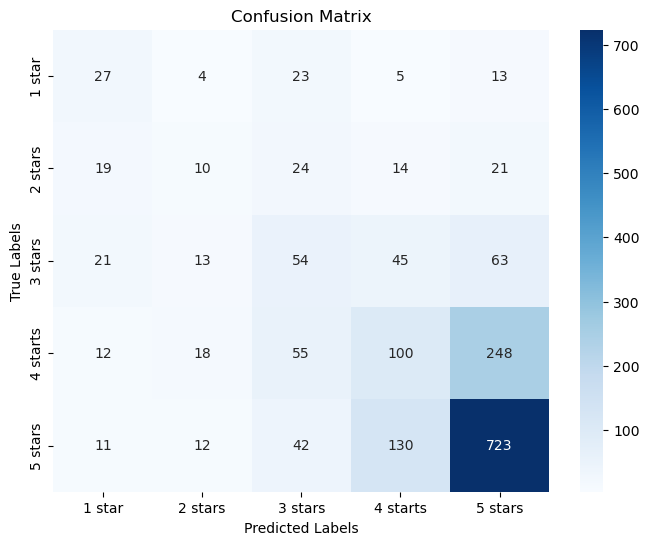

In [88]:
# Convert one-hot encoded true labels to class indices
y_true_indices = np.argmax(y_test, axis=1)

# Convert predicted labels to class indices
y_pred_indices = np.argmax(model.predict(X_test), axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_indices, y_pred_indices)

# Define class labels
class_labels = ['1 star', '2 stars', '3 stars', '4 starts', '5 stars']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()